### 优化、协作

In [ ]:
(* 要谈论优化，首先要有测量。 *)
Timing[FactorInteger[2^(2^8) + 1]]
AbsoluteTiming[FactorInteger[2^(2^8) + 1]]

pts = RandomReal[1, {10000, 2}];
gr = Graphics[Point /@ pts]
grMulti = Graphics[Point[pts]]
ByteCount /@ {gr, grMulti}

除此以外，还有 $MemoryInUse、MaxMemoryUsed、MemoryConstrained、\$RecursionLimit$等内存管理函数。

我们关心对时间的优化

* 不要造轮子

In [ ]:
myPrimeQ = Function[x, i = 2; max = Floor[Sqrt[x]] + 1;
   While[Mod[x, i] != 0 && i < max, i++]; Not[i < max]];
myPrimeSum = 
  Function[n, sum = 0; Do[If[myPrimeQ[x], sum += x], {x, 2, n}]; sum];

myPrimeSum2 = Plus @@ Prime /@ Range@PrimePi[#] &;

Timing[#[10^5]] & /@ {myPrimeSum, myPrimeSum2}

* 不要自己写循环

要尽可能地将循环都转化为表处理，因为 Mathematica 的内部循环永远比你写的循环快。

* 要善用数学。

P70: 欧拉总计函数与重排
<br>在小于$n$的数中, 与$n$互质的数的数目记为欧拉总计函数$\varphi(n)$.<br>

例如, 因为$1,2,4,5,7,8$均小于$9$且与$9$互质, 故$\varphi(9)=6$.<br>

$1$被认为和任意正整数互质, 所以$\varphi(1)=1$.<br>

有趣的是,$\varphi(87109)=79180$, 而$79180$恰好是$87109$的一个重排.<br>

在$1<n<10^7$中, 有些$n$满足$\varphi(n)$是$n$的一个重排<br>
求这些取值中使$\frac{n}{\varphi(n)}$最小的一个.




分析：\begin{aligned} \varphi (n) &= n\prod\limits_{p|n} {(1 - \frac{1}{p})}\\ \frac{n}{\varphi (n)} &= \prod\limits_{p|n} {\frac{p}{p - 1}}\\ \end{aligned}

所以要让这个比较小$n$取素数不就行了，遗憾的是$p$和$p-1$不可能为重排

所以最少就就是两个素数之积了, 千万以内 $66$ 万素数两两组合有 $2200 $亿种

\begin{aligned} \varphi (p_1 p_2) &= p_1 p_2(1 - \frac{1}{p_1})(1 - \frac{1}{p_2}) \\ &= (p_1 - 1)(p_2 - 1) \\ \frac{n}{\varphi (n)} &= \frac{p_1 p_2}{(p_1 - 1)(p_2 - 1)} \end{aligned}

这俩数之积要充分接近$ n$ 的话各自应该充分接近$\sqrt{n}$ , 搜索 $2\sqrt{n}$ 以下的就行

In [ ]:
foo[i_,j_]:=If[Equal@@Sort/@IntegerDigits/@{Prime[i]Prime[j],(Prime[i]-1)(Prime[j]-1)},{Prime[i],Prime[j]},Nothing];
data=Flatten[Table[foo[i,j],{i,2,PrimePi[2*^4]},{j,i+1,PrimePi[2*^4]-1}],1];
Numerator@First@Sort[#1 #2/(#1-1)/(#2-1)&@@@Select[data,#[[1]]#[[2]]<1*^7&]];

* 知道得越多，算得越快。

In [ ]:
vec = RandomReal[{-1, 1}, {10^6}];
Count[vec, _?Positive] // Timing
Total[Sign[vec] + 1]/2 // Timing

* 简单比复杂好。

In [ ]:
(For[i = 0; result = 0, i <= 10^6, i++, result += i]; result) // Timing
(result = 0; Do[result += i, {i, 10^6}]; result) // Timing

* 不要做无用的计算。

In [ ]:
Timing[N[Nest[(# + 3/#)/2 &, 1, 25], 100]]
Timing[Nest[N[(# + 3/#)/2, 100] &, 1, 25]]

* 纯函数比模式匹配快

In [ ]:
vec = RandomReal[{-100, 100}, 10^6];

f1 = #^2 + 1 &;
f2[x_] := x^2 + 1;

Timing[# /@ vec][[1]] & /@ {f1, f2}

上面所说的是一些较简单的优化技巧，光靠它们还是不能变出真正快速的程序。真正能够显著提速的技术是**并行化和编译**。

并行化是将计算任务分配到多个CPU或者它们的内部核心上<br>编译则是将函数编译为二进制代码。

{49.7657, -Graphics-}
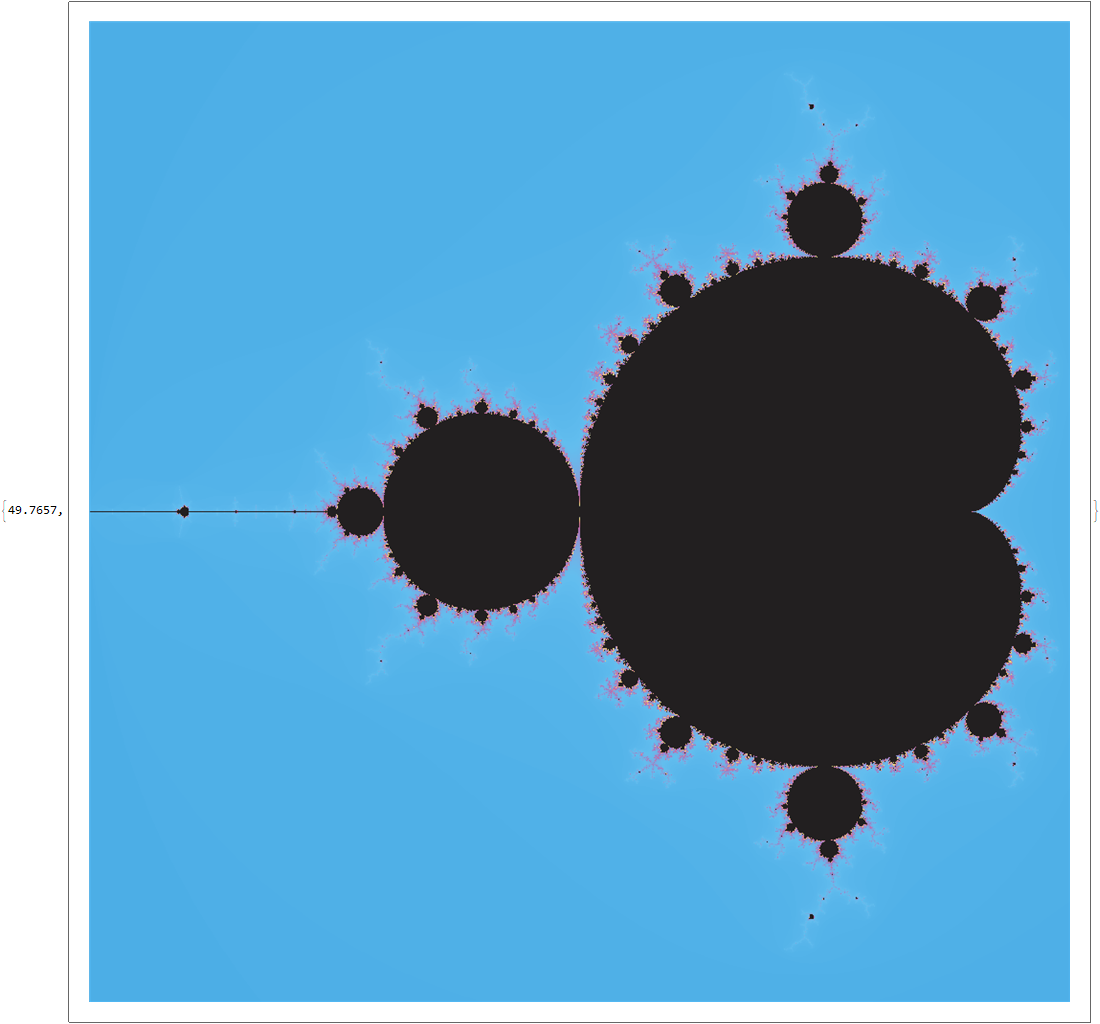

In [1]:
(* 并行化示例 *)
mandelbrot = 
  Compile[{{c, _Complex}}, 
   Length[NestWhileList[#^2 + c &, 0, Abs[#] < 2 &, 1, 250]], 
   CompilationTarget -> "C", RuntimeAttributes -> {Listable}, 
   Parallelization -> True, "RuntimeOptions" -> "Speed"];
   LaunchKernels[];
   DistributeDefinitions[mandelbrot];
   AbsoluteTiming[
 With[{n = 1024}, 
  ArrayPlot[
   ParallelTable[
    mandelbrot[x + I y], {y, -1.25, 1.25, 2.5/n}, {x, -2.0, 0.5, 
     2.5/n}], ColorFunction -> "CMYKColors", ImageSize -> n]]]

#### 与其它软件协作

Mathematica 不是万能的。

例如，用 C 或者 Fortran 语言编写的数值计算的程序一般来说会比 Mathematica 程序更有效率。

有的时候，我们发现某种功能已经由另外的软件很好地实现了，我们没有必要在 Mathematica 里重新实现一遍（"不要发明轮子"），所以希望能够直接调用外部程序。

有的时候，我们觉得 Mathematica 的某个内部函数不够快，想自己用 C 语言重新写一个，然后载入到 Mathematica 中。

反之，我们也可能想要在其它程序中调用 Mathematica 的内部函数。

Mathematica 内部有大量数学函数，可以调用数学、物理、化学、生物、地理、金融、语言等很多学科的数据

这些需求都要求 Mathematica 能够和其它程序进行各种层面的通讯和协作。

* 通过文件与其它程序交换数据

Get 可以将外部文件作为 Mathematica 表达式读取进来；Put 可以将 Mathematica 表达式导出为外部文件。

如果想导入或导出其它格式的文件，可以用 Import 和 Export。它们支持的格式非常全面，除了各种文本、图片、声音以外，甚至可以抓取网页和提交表单。

另外，Mathematica 还支持低级文件操作，如 OpenRead、OpenWrite、OpenAppend、Read、ReadList、Write、WriteString、Close 等等。

* 调用外部命令

Run[command] 可以调用外部命令，并获得外部命令的返回码（如果命令运行成功，返回码就是零）。<br>
RunThrough[command, input] 可以向外部命令投喂输入，并获得输出。如果无需输入，可取 input 为 Null。

In [ ]:
(* 利用 GAP 软件生成 Subscript[G, 2] 型单 Lie 代数的 7 维矩阵实现。 *)
file = OpenWrite["/Users/fft/prog.txt"];
WriteString[file, "L:=SimpleLieAlgebra(\"G\",2,Rationals);;\n"]
WriteString[file, "V:=HighestWeightModule(L,[1,0]);;\n"]
WriteString[file, "ll:=Basis(L);;\n"]
WriteString[file, "vv:=Basis(V);;\n"]
WriteString[file, "mm:=List(ll, x->MatrixOfAction(vv,x));;\n"]
WriteString[file, "PrintTo(\"result.txt\",mm);;"]
Close[file];
RunThrough["/usr/local/bin/gap -q prog.txt", "quit;;"];
L = ToExpression[
   StringReplace[
    Import["/Users/fft/result.txt"], {"[" -> "{", "]" -> "}", 
     "\n" -> "", " " -> ""}]];

In [ ]:
(* 利用 Andreas Gathmann 的 GROWI 程序计算 Gromov-Witten 不变量。 *)
ip = "192.168.56.101";
GWP[genus_, dimP_, term_] := Module[{tts},
  tts = Flatten[{term} //. {ttt_Times :> List @@ ttt, 
      ttt_^ppp_ :> Table[ttt, {ppp}]}];
  If[IntegerQ[
    degree = ((Plus @@ tts /. {t[i_, s_] :> i - 1 + s}) - 
        Length[tts] - (genus - 1) (3 - dimP))/(dimP + 1)], 
   RunThrough[
    "/usr/bin/ssh " <> ip <> " '/home/fft/.local/bin/growi G=" <> 
     ToString[genus] <> ",D=" <> ToString[degree] <> " in P\"^\"" <> 
     ToString[dimP] <> " thru " <> 
     StringJoin[
      Riffle[tts /. {t[i_, s_] :> 
          "H\"^\"" <> ToString[i - 1] <> "*psi\"^\"" <> ToString[s]}, 
       ","]] <> "'", Null], 0]]
  (* The number of algebraic curves with degree d passing through 3d-1 \
points. *)
Table[GWP[0, 2, t[3, 0]^(3 d - 1)], {d, 10}]
(* Quintic threefold, the first example of mirror symmetry \
phenomenon. *)
Array[Sum[
   MoebiusMu[
     k] RunThrough[
      "/usr/bin/ssh " <> ip <> " '/home/fft/.local/bin/growi G=0,D=" <>
        ToString[#/k] <> " in quintic threefold'", Null]/k^3, {k, 
    Divisors[#]}] &, 10]

* 用 C 语言为 Mathematica 写扩展

In [ ]:
:Begin:
:Function:       addtwo
:Pattern:        AddTwo[i_Integer, j_Integer]
:Arguments:      { i, j }
:ArgumentTypes:  { Integer, Integer }
:ReturnType:     Integer
:End:

:Evaluate: AddTwo::usage = "AddTwo[x, y] gives the sum of two machine integers x and y."

int addtwo( int i, int j)
{
	return i+j;
}

int main(int argc; char* argv[])
{
	return MLMain(argc, argv);
}

然后在命令行终端中执行

In [ ]:
mcc -o addtwo addtwo.tm

In [ ]:
link = Install["addtwo"]
?? AddTwo
AddTwo[2, 2]
Uninstall[link]

更多的例子可以在 Mathematica 安装目录的如下子目录中找到：<br>SystemFiles/Links/MathLink/DeveloperKit/Linux-x86-64/MathLinkExamples
<br>另外，还可以用 FindLibrary、LibraryLoad、LibraryUnload、LibraryFunctionLoad、LibraryFunctionUnload 等函数载入动态链接库。示例文件可以在如下目录找到：<br>
SystemFiles/Links/LibraryLink/LibraryResources/Source

* J/Link 和 .NET/Link

Mathematica 和所有外部程序的通讯都由 MathLink 完成，事实上，就连 Mathematica 自己的前端和内核、本地内核和远程内核、主内核和并行内核之间的通讯也全都是通过 MathLink 完成的。

MathLink 是一套协议，规定外部程序如何和 Mathematica 的内核进行通讯。前面我们演示的 addtwo.tm 的前半段就是在规定一些通讯时必要的信息，编译程序 mcc 则利用这些信息和后面的程序体生成一个真正可编译的 C 文件，然后利用系统自身的 gcc 程序编译这个 C 文件，得到的就是最后我们装入 Mathematica 的可执行文件 addtwo。临时生成的 C 文件最后被 mcc 程序删除了，如果想要保留它，可以加参数 -g：

In [ ]:
mcc -g -o addtwo addtwo.tm 

除了最基本的 MathLink 和前面提到过的 LibraryLink 以外，Mathematica 还提供了很多基于 MathLink 的包，方便我们将 Mathematica 与外部程序连接在一起。这其中最常用的两个是 J/Link 和 .NET/Link，分别用于连接 Java 虚拟机和 .Net 虚拟机。另外还有 RLink 用于连接 R 系统、DatabaseLink 用于链接数据库等等。除了 Mathematica 内部带的各种 Link 以外，还有一些第三方开发的 Link，比如将 Mathematica 嵌入到 Clojure 语言中的 Clojuratica、将 Mathematica 和 MATLAB 连在一起的MATLink、将 Mathematica 和 Excel连在一起的 ExcelLink 等等，它们都是基于最基本的 MathLink、LibraryLink、J/Link 和.NET/Link 的。这些包我们就不仔细介绍了，下面主要介绍一下 J/Link 和 .NET/Link。

要使用 J/Link 首先需要导入 JLink 包，然后用 InstallJava 启动 Java 虚拟机。为了看到标准输出，我们开启一个 Java 控制台，然后装入 Java 系统类，利用 System.out.println 函数向标准输出打印一句话。最后不要忘记*关闭* Java 虚拟机。

In [ ]:
Needs["JLink`"]
InstallJava[];
ShowJavaConsole[];

In [ ]:
LoadJavaClass["java.lang.System"];
System`out@println["Hello, Java! ----from Mathematica"]

In [ ]:
UninstallJava[];

.NET/Link 与 J/Link 用法很像，下面的程序需要在安装了 .NET Framework 的 Windows 系统上才能正确运行。

In [ ]:
Needs["NETLink`"]
InstallNET[];
ShowNETConsole[];
LoadNETType["System.Console"];
Console`WriteLine["Hello, .NET! ----from Mathematica"]
UninstallNET[];

更多用法请见系统自带的帮助和例子。